In [1]:
import pandas as pd
import geopandas as gpd

# Load data
df = pd.read_csv("sample_philippines_plate. csv")

# Convert Datetime column
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Timediff'] = ((df['Datetime'] - df['Datetime'].min()).dt.total_seconds())/86400

# Make GeoDataFrame with lon/lat
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Lon'], df['Lat']),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to UTM (auto-detect zone for centroid of data)
gdf = gdf.to_crs(gdf.estimate_utm_crs())

# Extract projected coordinates (in meters)
df['x'] = gdf.geometry.x   # Easting
df['y'] = gdf.geometry.y   # Northing

# Build feature matrix
features = df[['x', 'y', 'Timediff', 'Mag']].values
print(features)

[[-5.02657568e+05  1.45537944e+06  0.00000000e+00  6.10000000e+00]
 [-6.02985130e+05  1.58169560e+06  1.13237874e+02  6.40000000e+00]
 [ 4.76633236e+05  5.96866462e+04  1.21176837e+02  6.30000000e+00]
 ...
 [ 1.31353356e+06  2.50635285e+06  1.63863330e+04  4.80000000e+00]
 [-5.79970312e+05  5.89846445e+05  1.63896024e+04  5.30000000e+00]
 [ 1.00001537e+06  4.05280475e+06  1.63899452e+04  5.20000000e+00]]


In [2]:
# Data Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
print(features_scaled)

[[0.20761364 0.32610362 0.         0.5       ]
 [0.17713688 0.354407   0.00690898 0.575     ]
 [0.50509529 0.01337385 0.00739336 0.55      ]
 ...
 [0.75932262 0.56159289 0.99977961 0.175     ]
 [0.18412815 0.13216558 0.99997908 0.3       ]
 [0.6640844  0.90810292 1.         0.275     ]]


In [3]:
# Tuning the cluster_selection_epsilon
from sklearn.cluster import HDBSCAN
import numpy as np

eps_values = [0.0, 0.05, 0.1, 0.2, 0.5, 1.0]

for eps in eps_values:
    clusterer = HDBSCAN(min_cluster_size=2,
                        cluster_selection_epsilon=eps,
                        min_samples=3)
    labels = clusterer.fit_predict(features_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = np.mean(labels == -1)
    print(f"epsilon={eps}, clusters={n_clusters}, noise={noise_frac:.2f}")

epsilon=0.0, clusters=1086, noise=0.43
epsilon=0.05, clusters=277, noise=0.18
epsilon=0.1, clusters=20, noise=0.02
epsilon=0.2, clusters=2, noise=0.00
epsilon=0.5, clusters=2, noise=0.00
epsilon=1.0, clusters=2, noise=0.00


In [4]:
from sklearn.cluster import HDBSCAN

# Initialize the HDBSCAN model
hdb = HDBSCAN(min_cluster_size=2,
              min_samples=3,
              cluster_selection_epsilon=0.05
              )
hdb.fit(features_scaled)

,min_cluster_size,2
,min_samples,3
,cluster_selection_epsilon,0.05
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [5]:
import matplotlib.pyplot as plt

# Add the resulting cluster labels to the original DataFrame
df['Cluster'] = hdb.labels_

# Count the number of points in each cluster
# This helps understand the distribution of the data
print("--- Cluster ID counts ---")
print(df['Cluster'].value_counts())

--- Cluster ID counts ---
Cluster
 275    3005
 243    1613
-1      1538
 222     628
 264     211
        ... 
 140       2
 164       2
 52        2
 253       2
 269       2
Name: count, Length: 278, dtype: int64


In [6]:
# Classify mainshock, dependent shock and noise in each cluster
# Add a new column for the classification of each event
df['Type'] = 'Dependent'  # Initialize all as Unclassified

# Loop through each cluster (excluding noise: -1)
for cluster_id in sorted(df['Cluster'].unique()):
    if cluster_id == -1: # if cluster id is not equal to -1
        continue  # skip noise

    sub_df = df[df['Cluster'] == cluster_id]  # Make each cluster as a subset from the whole dataframe

    # Identify the mainshock (largest magnitude)
    mainshock_idx = sub_df['Mag'].idxmax()
    mainshock_time = sub_df.at[mainshock_idx, 'Datetime']

    # Assign mainshock
    df.at[mainshock_idx, 'Type'] = 'Mainshock'

# Assign noise (they might be independent shocks)
df.loc[df['Cluster'] == -1, 'Type'] = 'Noise'

print(df)

            Date    Lat     Lon  Depth  Mag  Strike  Dip  Rake        Time  \
0     1976/02/15  13.00  125.79   33.0  6.1     322   39   -73  01:54:23.1   
1     1976/06/07  14.09  124.83   33.0  6.4     249   67   180  07:36:55.4   
2     1976/06/15   0.54  134.79   33.0  6.3      86   87    -1  06:09:01.8   
3     1976/06/26   3.66  126.75   33.0  6.5     169   26    69  10:30:59.4   
4     1976/08/16   6.26  124.02   33.0  7.9     341   35    92  16:11:07.3   
...          ...    ...     ...    ...  ...     ...  ...   ...         ...   
8356  2020/12/25   5.05  125.91  100.6  5.1     125   44    16  02:00:33.4   
8357  2020/12/25  13.30  122.33   10.0  5.4     313   79    10  10:04:34.3   
8358  2020/12/26  22.47  142.89  178.1  4.8      10   30    49  09:53:50.3   
8359  2020/12/29   5.26  125.30   35.0  5.3     352    7   107  16:21:48.1   
8360  2020/12/30  36.49  140.58   50.0  5.2     200   32    92  00:35:28.4   

                    Datetime      Timediff             x       

In [7]:
df['Type'].unique()

array(['Noise', 'Dependent', 'Mainshock'], dtype=object)

In [8]:
# ========================================
# Estimation and further data exploration
# ========================================

In [9]:
# Visualise the clustered sequence on map
import plotly.express as px

df_noise_excluded = df[df['Type'] != 'Noise']

df_noise_excluded['Cluster'] = df_noise_excluded['Cluster'].astype('category')

fig = px.scatter_map(
    df_noise_excluded,
    lat='Lat',
    lon='Lon',
    hover_name='Cluster',
    color='Cluster',
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    zoom=3,
    height=800,
    map_style='carto-positron',
    title='Earthquake Clustering using HDBSCAN <br><sup>Time of occurrence: 1976-2020 | Philippine Plate</sup>'
)

fig.show()

/var/folders/fn/9d0nx8h147x36gzgyptphd8w0000gn/T/ipykernel_37712/2626665052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_excluded['Cluster'] = df_noise_excluded['Cluster'].astype('category')


In [10]:
# Extract the mainshock sequence
declustered_mainshock_hdbscan = df[(df['Type'] == 'Mainshock')].copy()

# Compute inter-arrival timesCompute inter-arrival times to second
declustered_mainshock_hdbscan['inter_arrival'] = declustered_mainshock_hdbscan['Datetime'].diff().dt.total_seconds()
print(declustered_mainshock_hdbscan)

            Date    Lat     Lon  Depth  Mag  Strike  Dip  Rake        Time  \
23    1977/03/02   6.77  123.74   52.0  6.1     271   41    53  09:53:23.2   
28    1977/03/21  13.20  145.28   33.0  5.6     230   41   126  06:57:44.4   
37    1977/05/12  13.03  121.71   33.0  5.4      42   65  -172  08:09:52.9   
41    1977/05/21  27.58  140.00  340.0  5.1     124   36  -132  13:40:55.0   
46    1977/06/17  19.04  145.69  108.0  5.6     230   64   175  14:45:09.4   
...          ...    ...     ...    ...  ...     ...  ...   ...         ...   
8199  2020/07/05  36.37  137.84   10.0  4.7     272   81   175  06:09:35.9   
8201  2020/07/06  21.03  144.86  125.0  5.5      57   23    31  12:58:04.3   
8240  2020/08/18  12.03  124.13   10.0  6.6     323   87     1  00:03:48.6   
8308  2020/11/07  25.71  143.60   16.0  5.8     171   37   -86  01:10:32.1   
8311  2020/11/10  12.20  140.30   10.0  5.2     176   62  -153  01:51:50.0   

                    Datetime      Timediff             x       

In [11]:
# The Statistic Features of the Mainshock Sequence
print("The declustered catalogue contains {} events.".format(len(declustered_mainshock_hdbscan)))

max_interval_days = round(declustered_mainshock_hdbscan['inter_arrival'].max() / (24*60*60))
print("The maximum interarrival time between two neighbour independent events is {} days.".format(max_interval_days))

min_interval_min = round(declustered_mainshock_hdbscan['inter_arrival'].min() / 60)
print("The minimum interarrival time between two neighbour independent events is {} minutes.".format(min_interval_min))

The declustered catalogue contains 277 events.
The maximum interarrival time between two neighbour independent events is 381 days.
The minimum interarrival time between two neighbour independent events is 9 minutes.


In [12]:
# Visualise the declustered mainshock sequence on map
import plotly.express as px

fig_mainshock = px.scatter_map(
    declustered_mainshock_hdbscan,
    lat='Lat',
    lon='Lon',
    hover_name='Mag',
    size='Mag',
    size_max=8,
    color='Mag',
    color_continuous_scale='orrd',
    hover_data={'Date', 'Time', 'Lat', 'Lon'},
    zoom=3,
    height=800,
    map_style='carto-positron',
    title='Declustered Mainshock Sequence using HDBSCAN<br><sup>Time of occurrence: 1976-2020 ｜ Philippine Plate</sup>'
)

fig_mainshock.show()

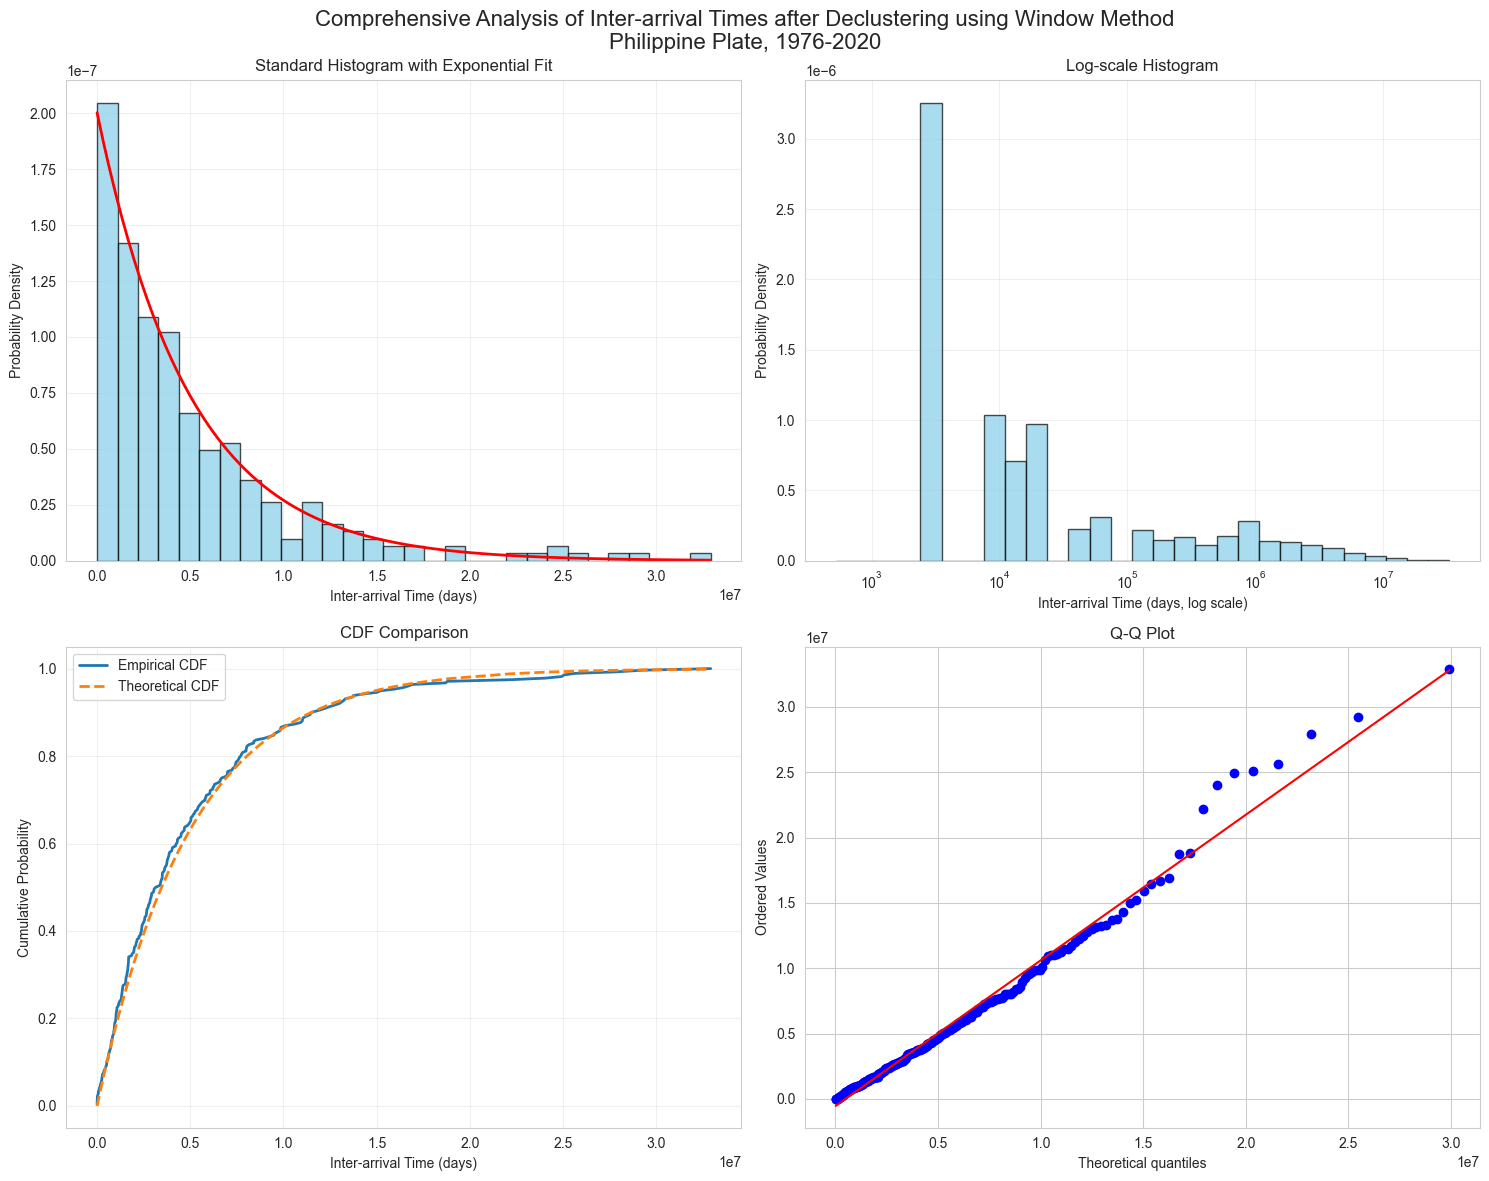

In [18]:
# Visualisation: The inter_arrival times are expected to fit an exponential distribution
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import probplot

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

# Comprehensive analysis for the raw catalogue
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Standard Histogram with Exponential Fit (Top-Left)
axes[0, 0].hist(x, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_range = np.linspace(x.min(), x.max(), 100)
axes[0, 0].plot(x_range, expon.pdf(x_range, loc, scale), 'r-', lw=2)
axes[0, 0].set_title('Standard Histogram with Exponential Fit')
axes[0, 0].set_xlabel('Inter-arrival Time (days)')
axes[0, 0].set_ylabel('Probability Density')
axes[0, 0].grid(True, alpha=0.3)

# Log-scale Histogram (Top-Right)
bins = np.logspace(np.log10(x.min()), np.log10(x.max()), 30)
axes[0, 1].hist(x, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Log-scale Histogram')
axes[0, 1].set_xlabel('Inter-arrival Time (days, log scale)')
axes[0, 1].set_ylabel('Probability Density')
axes[0, 1].grid(True, alpha=0.3)

# CDF Comparison (Bottom-Left)
x_sorted = np.sort(x)
y_ecdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
y_theoretical = expon.cdf(x_sorted, loc, scale)
axes[1, 0].plot(x_sorted, y_ecdf, label='Empirical CDF', linewidth=2)
axes[1, 0].plot(x_sorted, y_theoretical, label='Theoretical CDF', linestyle='--', linewidth=2)
axes[1, 0].set_title('CDF Comparison')
axes[1, 0].set_xlabel('Inter-arrival Time (days)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot (Bottom-Right)
probplot(x, dist=expon, sparams=(loc, scale), plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.savefig('comprehensive_analysis_philippine_hdbscan.png', dpi=300, bbox_inches='tight')
plt.suptitle('Comprehensive Analysis of Inter-arrival Times after Declustering using Window Method\nPhilippine Plate, 1976-2020', fontsize=16)
plt.tight_layout()
plt.show()

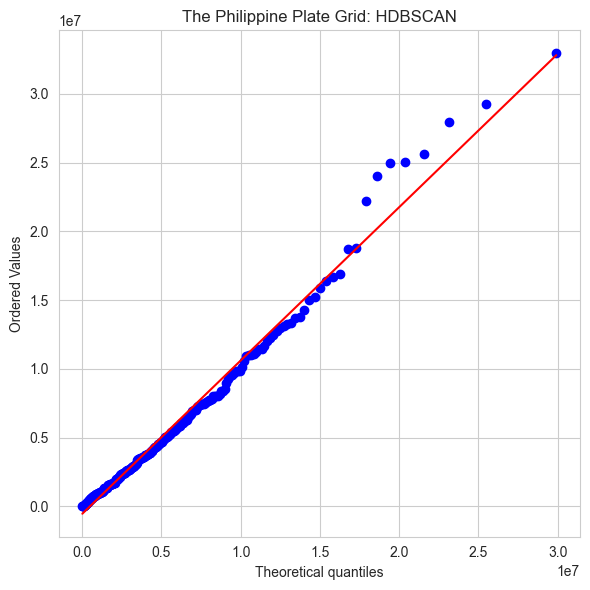

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import probplot

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

plt.figure(figsize=(6, 6))
probplot(x, dist=expon, sparams=(loc, scale), plot=plt)
plt.title("The Philippine Plate Grid: HDBSCAN")
plt.tight_layout()
plt.savefig("qq_philippine_hdbscan.png", dpi=300)
plt.show()

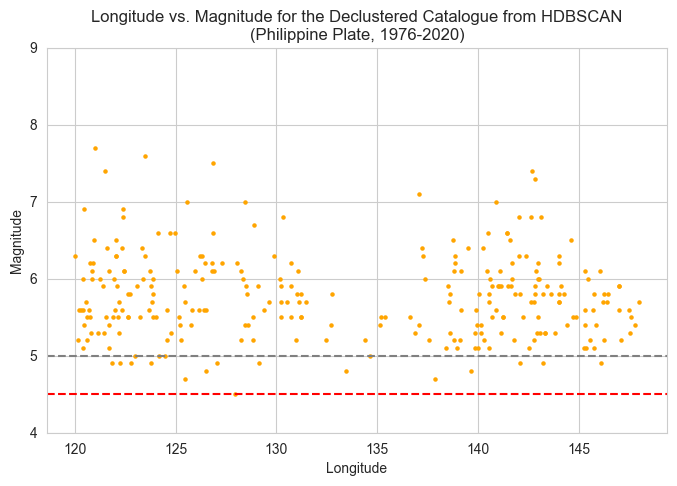

In [15]:
# Lon vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lon']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 9)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Longitude")
plt.ylabel("Magnitude")
plt.title("Longitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(Philippine Plate, 1976-2020)")
plt.show()

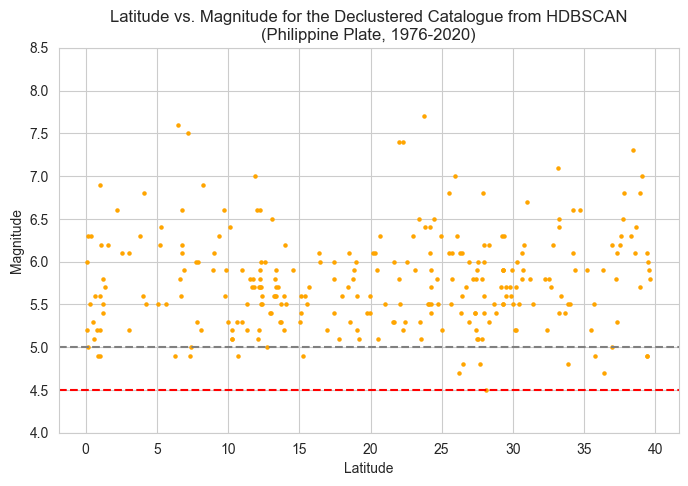

In [19]:
# Lat vs Mag
import matplotlib.pyplot as plt

x = declustered_mainshock_hdbscan['Lat']
y = declustered_mainshock_hdbscan['Mag']

plt.figure(figsize=(8, 5))
plt.ylim(4, 8.5)
plt.scatter(x, y, s=5, color='orange')
plt.axhline(y=4.5, color='red', linestyle='--')  # Observing the minor magnitude(<4.5) events for comparison
plt.axhline(y=5, color='grey', linestyle='--')  # Observing the minor magnitude events(<5) for comparison
plt.xlabel("Latitude")
plt.ylabel("Magnitude")
plt.title("Latitude vs. Magnitude for the Declustered Catalogue from HDBSCAN\n(Philippine Plate, 1976-2020)")
plt.show()

In [17]:
# KS test
from scipy.stats import kstest, expon

x = declustered_mainshock_hdbscan['inter_arrival'].dropna()
loc, scale = expon.fit(x)

stat, p_value = kstest(x, 'expon', args=(loc, scale))

# If p_value > 0.05, the inter-arrival times are consistent with an exponential distribution.
# This implies that the earthquake occurrences follow a Poisson process.
print(f"K-S test p-value: {p_value:.4f}")
print(f"K-S Test Statistic (D): {stat:.4f}")

METHOD_NAME = "HDBSCAN"
if p_value > 0.05:
    # We fail to reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is consistent with a Poisson process.")
else:
    # We reject the null hypothesis.
    print(f"The declustered catalogue from the {METHOD_NAME} method is not consistent with a Poisson process.")

K-S test p-value: 0.4139
K-S Test Statistic (D): 0.0527
The declustered catalogue from the HDBSCAN method is consistent with a Poisson process.
